# Статистический анализ данных / Python
## Задание 4

**Правила:**

* Дедлайн **8 декаюря 23:59**.
* Выполненную работу нужно отправить на почту ` mipt.stats@yandex.ru`, указав тему письма `"[MADE19] Фамилия Имя - задание 4"`. Квадратные скобки обязательны. Если письмо дошло, придет ответ от автоответчика.
* Прислать нужно ноутбук и его pdf-версию (без архивов), которую можно сделать с помощью печати в файл через инструменты браузера.
* Для выполнения задания используйте этот ноутбук в качествие основы, ничего не удаляя из него. 
* Разделяйте код вычислений и отрисовки графиков. Так будет удобнее вам и проверяющим.


In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.sandbox.stats.multicomp import multipletests
from tqdm import tqdm_notebook

sns.set(font_scale=1.2)


__________________
### Задача 1. (3 балла)

С помощью критерия хи-квадрат проверьте, действительно ли код `sps.poisson(mu=5).rvs(size=1000)` генерирует выборку размера 1000 из пуассоновского распределения с параметром 5. 

*Указания*
1. Не забудьте учесть условия применимости критерия хи-квадрат;
2. Для вычисления плотности воспользуйтесь `sps.poisson(mu=5).pmf`;
3. Для подсчета количества элементов в разбиении на множества воспользуйтесь `np.unique(sample, return_counts=True)`;
4. Не нужно писать сколь-либо универсальный код, который одним нажатием кнопки проверяет гипотезу с учетом всех условий применимости критерия. Расписывайте код поэтапно, на каждый логический этап свой код для *конкретной* реализации выборки. Так проще реализовать, и проще проверять.

In [2]:
sample_size = 1000
sample = sps.poisson(mu=5).rvs(size=sample_size)

# Посчитаем количесто одинаковых значений в обучающей выборке для выбора интервалов
counts = np.unique(sample, return_counts=True)
values_df = pd.DataFrame({'value': counts[0], 'count': counts[1]})
values_df

,value,count
0,0,10
1,1,40
2,2,75
3,3,145
4,4,166
5,5,184
6,6,142
7,7,105
8,8,73
9,9,34


In [3]:
interval_boundaries=[-0.5, 1.5, *np.arange(2.5, 10.51), 20.5] # границы интервалов

# Разбиваем на интервалы, считаем наблюдаемое количество элементов в интервалах
intervals_df = pd.cut(sample, bins=interval_boundaries).value_counts().reset_index()\
    .rename(columns={'index': 'interval', 0: 'observed_count'})

expected_count = np.zeros(len(intervals_df))

for i, (interval, _) in intervals_df.iterrows():
    for value in range(20):
        if value in interval:
            # Считаем вероятности попадания в интервал
            expected_count[i] += sps.poisson(mu=5).pmf(value)
# Домножаем на размер выборки - получаем ожидаемое (теоретическое) количество элементов в интервалах
expected_count *= sample_size
intervals_df['expected_count'] = expected_count
intervals_df

,interval,observed_count,expected_count
0,"(-0.5, 1.5]",50,40.427682
1,"(1.5, 2.5]",75,84.224337
2,"(2.5, 3.5]",145,140.373896
3,"(3.5, 4.5]",166,175.467370
4,"(4.5, 5.5]",184,175.467370
5,"(5.5, 6.5]",142,146.222808
6,"(6.5, 7.5]",105,104.444863
7,"(7.5, 8.5]",73,65.278039
8,"(8.5, 9.5]",34,36.265577
9,"(9.5, 10.5]",12,18.132789


In [4]:
sps.chisquare(intervals_df['observed_count'], intervals_df['expected_count'])

Power_divergenceResult(statistic=7.615845397536903, pvalue=0.6663034380127963)

**Вывод:**

Выборка согласуется с распределением Пуассона c математическим ожиданием равным 5, так как p-value больше 0.05. Что неудивительно, ведь мы ее сгенерировали из распределения Пуассона с данным параметром.

__________________
### Задача 2. (5 баллов)


Cкачайте данные <a href="http://archive.ics.uci.edu/ml/datasets/wine">`wine dataset`</a>, взяв все колонки, кроме `Class`.

In [5]:
df = pd.read_csv('wine.data',
                 names=['class_id', 'Alcohol', 'Malic acid',
                        'Ash', 'Alcalinity of ash', 'Magnesium',
                        'Total phenols', 'Flavanoids',
                        'Nonflavanoid phenols', 'Proanthocyanins',
                        'Color intensity', 'Hue',
                        'OD280/OD315 of diluted wines', 'Proline']).drop(columns='class_id')

Для каждого параметра нарисуте Q-Q plot. Для наглядности и экономии места рисуйте графики в несколько столбцов, используя `plt.subplot`.

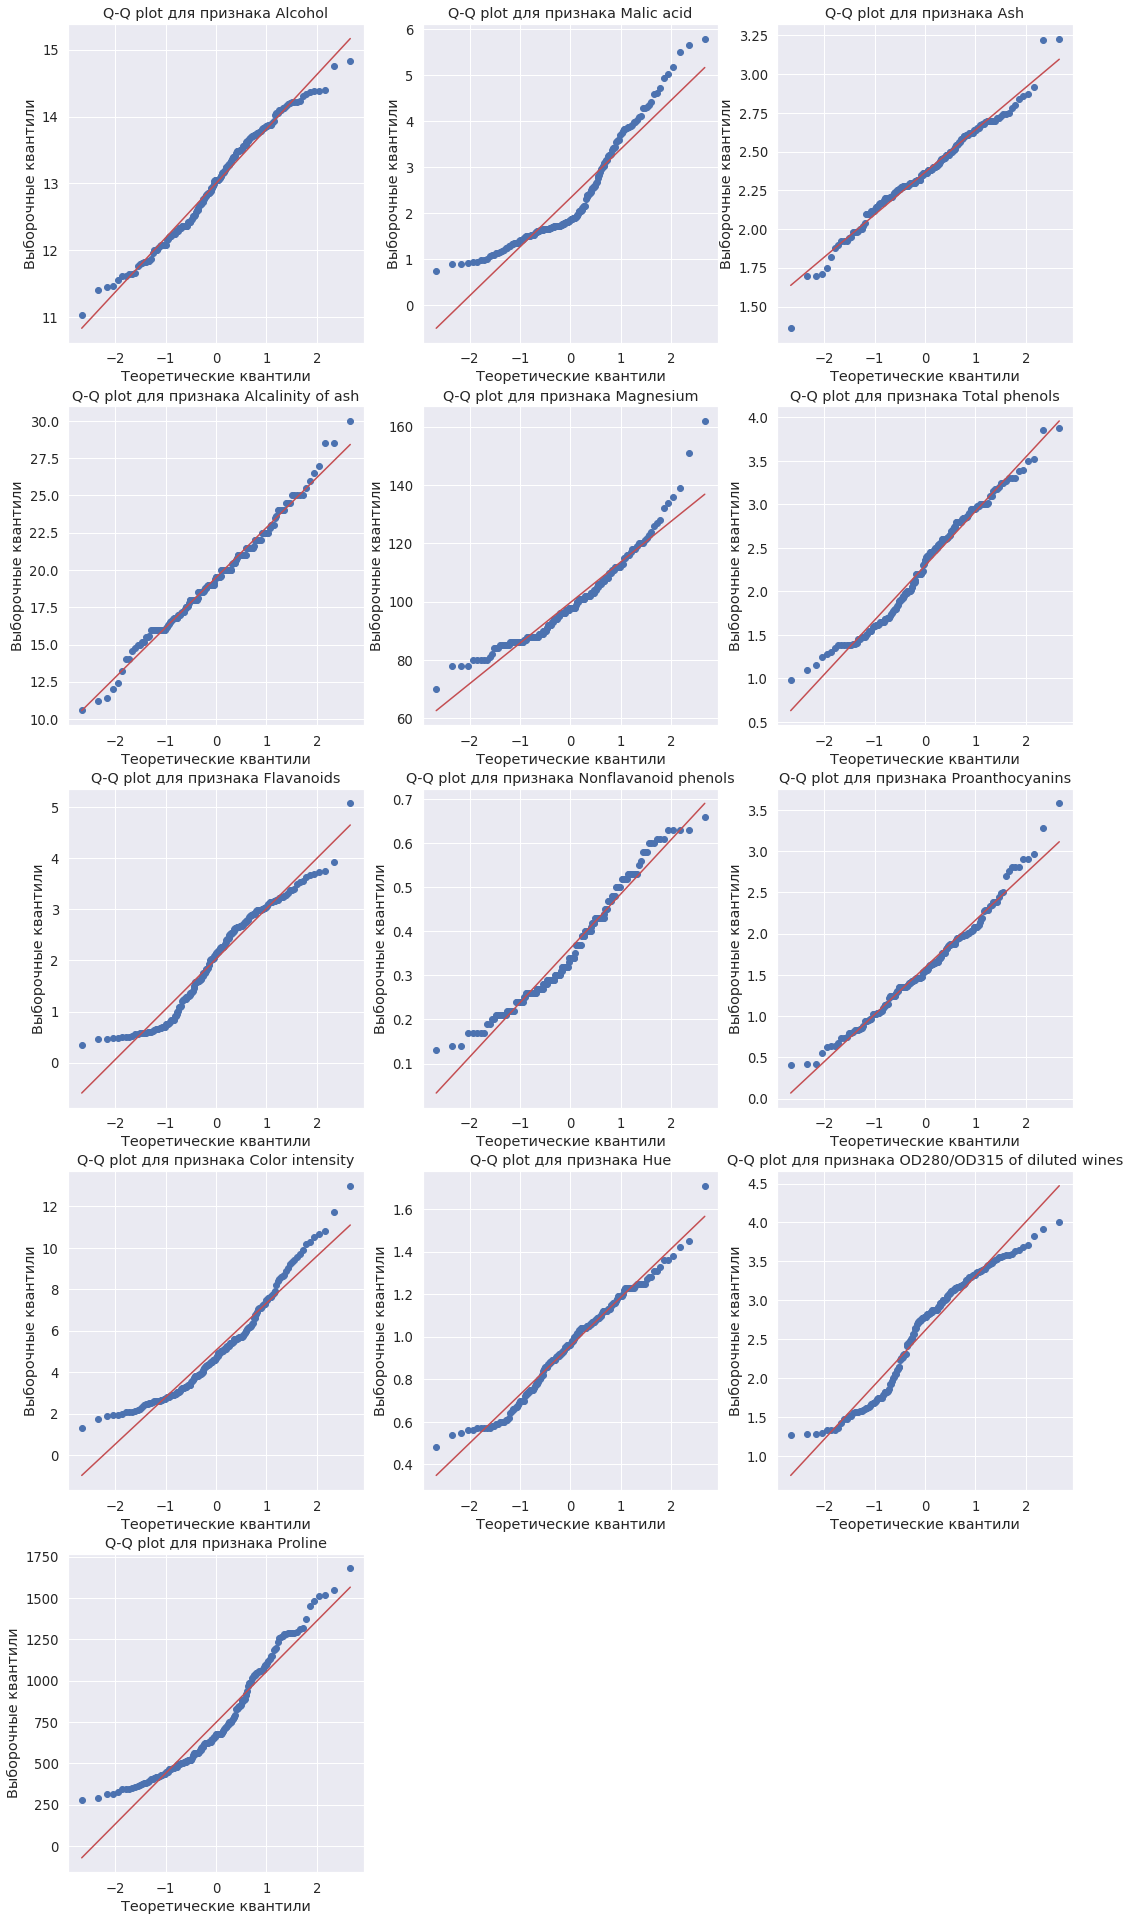

In [21]:
fig = plt.figure(figsize=(18, 34))

for i, feature in enumerate(df.columns):
    ax = plt.subplot(5, 3, i+1)
    sps.probplot(df[feature], dist='norm', plot=ax);
    ax.set_title(f'Q-Q plot для признака {feature}')
    ax.set_xlabel('Теоретические квантили')
    ax.set_ylabel('Выборочные квантили')

Для каких параметров можно говорить об их нормальности и почему?

**Ответ:** Можно сказать, что распределения признаков Alcohol, Ash, Alcalinity of ash, Proanthocyanins, Hue согласуется с нормальным, так как точки $(X_{(i)}, F_{0, 1}^{-1}(\frac{i}{n+1}))$ примерно лежат на одной прямой.

$F_{0, 1}^{-1}$ - функция, обратная функции распределения нормального распределения с параметрами 0, 1.

Проверьте нормальность каждого параметра статистическими критериями. Прежде чем выполнить следующую часть задачи, ответьте на вопросы.

Для каждого параметра используйте несколько критериев проверки нормальности. Какие критерии вы будете использовать?

**Ответ:** критерий Колмогорова, критерий Шапиро-Уилка, критерий Жарка-Бера

Результаты критериев нужно обработать с помощью *одной* процедуры множественной проверки гипотез для всех параметров и всех критериев сразу. Почему так нужно делать?

**Ответ:** Если делать МПГ отдельно для каждого признака, то вероятность ошибочно отвергнуть нормальность хотя бы одного из признаков равна $1 - (1-0,05)^{13} \approx 0.48$.

Какой метод для контроля FWER стоит применить и почему?

**Ответ:** Метод Холма, т.к. он мощнее метода Бонферрони. Метод Холма-Шидака использовать нельзя, так как выборки разных признаков одних и тех же объектов будут зависимыми выборками.

Как понять из результата процедуры множественной проверки гипотез, нормальность каких параметров следует отклонить?

**Ответ:** Если хоть одна нулевая гипотеза для конкретного признака отвергнута, то нормальность этого признака следует отклонить.

Если нормальность не отклоняется, что можно сказать про выборку (ответ в презентации с лекции)? 

**Ответ:** Выборка согласуется с основной гипотезой. Данные не противоречат проверяемым свойствам нормального распределения.

Реализуйте данную схему. Предварительно соберите p-value всех критериев в таблицу. 

Функция `multipletests` принимает только одномерные массивы, поэтому для полученной `numpy`-таблицы нужно воспользоваться методом `ravel`. Результат нужно собрать обратно в таблицу с помощью метода `reshape`, которому нужно передать размерности таблицы. Для наглядности сделайте таблицу с помощью `pandas.DataFrame`. В качестве названий строк используйте названия переменных, а названий столбцов --- используемые критерии.

In [7]:
p_values = np.zeros((df.shape[1], 3))

for i, feature in enumerate(df.columns):
    p_values[i]=(sps.kstest(df[feature], sps.norm(*sps.norm.fit(df[feature])).cdf)[1],
                 sps.jarque_bera(df[feature])[1],
                 sps.shapiro(df[feature])[1])

p_values_df = pd.DataFrame(p_values,index=df.columns,
                           columns={'Kolmogorov p-value',
                                    'Jarque-Bera p-value',
                                    'Shapiro p-value'})

# Поменяем формат отображения чисел в pandas,
# чтобы на числа было удобнее смотреть
pd.set_option('display.float_format', lambda x: '%.3f' % x)

p_values_df

,Jarque-Bera p-value,Shapiro p-value,Kolmogorov p-value
Alcohol,0.359,0.061,0.020
Malic acid,0.000,0.000,0.000
Ash,0.584,0.008,0.039
Alcalinity of ash,0.460,0.251,0.264
Magnesium,0.110,0.000,0.000
Total phenols,0.290,0.063,0.004
Flavanoids,0.136,0.053,0.000
Nonflavanoid phenols,0.016,0.011,0.000
Proanthocyanins,0.606,0.008,0.014
Color intensity,0.104,0.000,0.000


In [8]:
rejects, p_values_corrected = multipletests(p_values.ravel(), method='holm')[:2]

In [9]:
p_values_corrected_df = pd.DataFrame(p_values_corrected.reshape(p_values.shape),
                                     index=df.columns,
                                     columns={'Kolmogorov corrected p-value',
                                              'Jarque-Bera corrected p-value',
                                              'Shapiro corrected p-value'})
p_values_corrected_df

,Jarque-Bera corrected p-value,Kolmogorov corrected p-value,Shapiro corrected p-value
Alcohol,1.000,0.855,0.341
Malic acid,0.000,0.000,0.000
Ash,1.000,0.195,0.619
Alcalinity of ash,1.000,1.000,1.000
Magnesium,1.000,0.000,0.000
Total phenols,1.000,0.855,0.114
Flavanoids,1.000,0.791,0.001
Nonflavanoid phenols,0.310,0.236,0.003
Proanthocyanins,1.000,0.188,0.294
Color intensity,1.000,0.000,0.000


In [10]:
print('Не отвергается нормальность признаков',
      ', '.join(df.columns[~rejects.reshape(p_values.shape).any(axis=1)]))

Не отвергается нормальность признаков Alcohol, Ash, Alcalinity of ash, Total phenols, Proanthocyanins, Hue


Для каких параметров нормальность не отвергается?

**Ответ:** Не отвергается нормальность признаков Alcohol, Ash, Alcalinity of ash, Total phenols, Proanthocyanins, Hue.